In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from multiprocessing import Pool
from xgboost import XGBClassifier, plot_importance
from imblearn.over_sampling import SMOTE, SMOTENC
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.under_sampling import TomekLinks, RandomUnderSampler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
tqdm.pandas()
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [2]:
train = pd.read_csv('Data/train.csv')
test = pd.read_csv('Data/test.csv')

In [3]:
print("Shape of Train: ", train.shape)
train.head()

Shape of Train:  (450000, 20)


,order_time,order_id,order_date,allot_time,accept_time,pickup_time,delivered_time,rider_id,first_mile_distance,last_mile_distance,alloted_orders,delivered_orders,cancelled,undelivered_orders,lifetime_order_count,reassignment_method,reassignment_reason,reassigned_order,session_time,cancelled_time
0,2021-01-26 02:21:35,556753,2021-01-26 00:00:00,2021-01-26 02:21:59,2021-01-26 02:22:08,2021-01-26 02:32:51,2021-01-26 02:49:47,11696,1.5666,2.65,46.0,46.0,0,0.0,621.0,NaN,NaN,NaN,NaN,NaN
1,2021-01-26 02:33:16,556754,2021-01-26 00:00:00,2021-01-26 02:33:57,2021-01-26 02:34:45,2021-01-26 02:50:25,2021-01-26 03:11:15,18117,2.5207,2.76,8.0,8.0,0,0.0,105.0,NaN,NaN,NaN,3.266667,NaN
2,2021-01-26 02:39:49,556755,2021-01-26 00:00:00,2021-01-26 02:39:57,2021-01-26 02:40:13,2021-01-26 02:56:00,2021-01-26 03:12:46,18623,2.2074,4.80,1.0,1.0,0,0.0,66.0,NaN,NaN,NaN,9.816667,NaN
3,2021-01-26 02:47:53,556756,2021-01-26 00:00:00,2021-01-26 02:48:25,2021-01-26 02:49:06,2021-01-26 03:21:51,2021-01-26 03:41:05,15945,2.1894,6.38,1.0,1.0,0,0.0,127.0,NaN,NaN,NaN,17.533333,NaN
4,2021-01-26 03:06:30,556757,2021-01-26 00:00:00,2021-01-26 03:07:21,2021-01-26 03:07:57,2021-01-26 03:31:38,2021-01-26 04:00:15,17589,2.7870,4.01,34.0,34.0,0,0.0,84.0,NaN,NaN,NaN,1.350000,NaN


In [4]:
train['cancelled'].value_counts()

0    444782
1      5218
Name: cancelled, dtype: int64

Feature Ideas:
- Time to Allot Order to Rider
- Time taken by rider to accept order
- Time for Food Preparation
- Time taken for delivery from time of order
- Check if there is an overlap between rider ID in train and test, if there is, add a column for rider cancellation rate
- If clustering happens for time of day of cancellation, add as a feature
- Ratio of first mile to last mile distance

Cleaning Ideas:
- lifetime_order_count change as per date
- interpolate based on rider_id for session time

Future Ideas:
- Subsample first and then smote in order to prevent smote from messing up

In [5]:
train[train['accept_time'].isna()].head()

,order_time,order_id,order_date,allot_time,accept_time,pickup_time,delivered_time,rider_id,first_mile_distance,last_mile_distance,alloted_orders,delivered_orders,cancelled,undelivered_orders,lifetime_order_count,reassignment_method,reassignment_reason,reassigned_order,session_time,cancelled_time
1700,2021-01-26 06:35:16,558453,2021-01-26 00:00:00,2021-01-26 06:35:18,NaN,NaN,NaN,15903,1.8026,8.55,50.0,50.0,1,0.0,1216.0,NaN,NaN,NaN,51.300000,2021-01-26 06:40:17
4066,2021-01-26 07:20:44,560819,2021-01-26 00:00:00,2021-01-26 07:20:45,NaN,NaN,NaN,3430,1.6112,4.29,29.0,29.0,1,0.0,190.0,NaN,NaN,NaN,52.700000,2021-01-26 07:21:20
9296,2021-01-26 08:58:12,566050,2021-01-26 00:00:00,2021-01-26 08:58:41,NaN,NaN,NaN,20621,2.8689,4.07,NaN,NaN,1,NaN,917.0,NaN,NaN,NaN,120.733333,2021-01-26 09:00:35
13365,2021-01-26 12:42:36,570118,2021-01-26 00:00:00,2021-01-26 12:42:37,NaN,NaN,NaN,10605,0.7966,3.14,11.0,11.0,1,0.0,1546.0,NaN,NaN,NaN,478.333333,2021-01-26 12:47:37
13429,2021-01-26 12:45:42,570182,2021-01-26 00:00:00,2021-01-26 12:45:43,NaN,NaN,NaN,3585,0.9797,7.79,67.0,65.0,1,2.0,144.0,NaN,NaN,NaN,325.666667,2021-01-26 12:47:38


In [10]:
print("Shape of Test: ", test.shape)
test.head()

Shape of Test:  (144844, 16)


,order_time,order_id,order_date,allot_time,accept_time,rider_id,first_mile_distance,last_mile_distance,alloted_orders,delivered_orders,undelivered_orders,lifetime_order_count,reassignment_method,reassignment_reason,reassigned_order,session_time
0,2021-02-06 10:03:24,130231,2021-02-06 00:00:00,2021-02-06 10:03:49,2021-02-06 10:04:15,12884,1.6585,4.54,216.0,215.0,1.0,747.0,NaN,NaN,NaN,273.400000
1,2021-02-06 10:03:26,130232,2021-02-06 00:00:00,2021-02-06 10:03:27,2021-02-06 10:03:36,3541,2.0709,5.84,52.0,52.0,0.0,75.0,NaN,NaN,NaN,252.100000
2,2021-02-06 10:03:27,130233,2021-02-06 00:00:00,2021-02-06 10:04:14,2021-02-06 10:05:34,603,1.3884,0.99,289.0,289.0,0.0,2214.0,NaN,NaN,NaN,241.383333
3,2021-02-06 10:03:29,130234,2021-02-06 00:00:00,2021-02-06 10:03:30,2021-02-06 10:03:53,3414,1.9039,2.59,125.0,122.0,3.0,1020.0,NaN,NaN,NaN,291.933333
4,2021-02-06 10:03:35,130235,2021-02-06 00:00:00,2021-02-06 10:03:43,2021-02-06 10:04:43,1426,0.8275,0.94,352.0,350.0,2.0,7284.0,NaN,NaN,NaN,247.133333


In [11]:
len(set(train['rider_id']).intersection(set(test['rider_id'])))

11652

In [12]:
len(test['rider_id'].unique())

13682

In [13]:
train[train['rider_id'] == 1].head(10)

,order_time,order_id,order_date,allot_time,accept_time,pickup_time,delivered_time,rider_id,first_mile_distance,last_mile_distance,alloted_orders,delivered_orders,cancelled,undelivered_orders,lifetime_order_count,reassignment_method,reassignment_reason,reassigned_order,session_time,cancelled_time
315699,2021-02-03 06:43:10,239802,2021-02-03 00:00:00,2021-02-03 06:43:25,2021-02-03 06:43:30,2021-02-03 06:55:20,2021-02-03 07:12:18,1,1.4561,4.14,6.0,6.0,0,0.0,1380.0,NaN,NaN,NaN,147.533333,NaN
328569,2021-02-03 13:38:38,252675,2021-02-03 00:00:00,2021-02-03 13:38:55,2021-02-03 13:40:17,2021-02-03 14:06:26,2021-02-03 14:46:21,1,2.4127,3.58,6.0,6.0,0,0.0,1380.0,NaN,NaN,NaN,510.566667,NaN
331400,2021-02-03 14:02:48,255506,2021-02-03 00:00:00,2021-02-03 14:04:44,2021-02-03 14:05:50,2021-02-03 14:15:04,2021-02-03 14:33:03,1,0.8029,3.68,6.0,6.0,0,0.0,1380.0,NaN,NaN,NaN,534.733333,NaN
346038,2021-02-03 16:14:20,270142,2021-02-03 00:00:00,2021-02-03 16:14:55,2021-02-03 16:15:50,2021-02-03 16:31:13,2021-02-03 16:40:45,1,1.1215,3.58,6.0,6.0,0,0.0,1380.0,NaN,NaN,NaN,666.266667,NaN
348876,2021-02-03 16:41:11,272980,2021-02-03 00:00:00,2021-02-03 16:41:47,2021-02-03 16:42:43,2021-02-03 16:49:22,2021-02-03 16:58:00,1,0.4628,1.51,6.0,6.0,0,0.0,1380.0,NaN,NaN,NaN,693.116667,NaN
352353,2021-02-03 17:14:48,276457,2021-02-03 00:00:00,2021-02-03 17:15:39,2021-02-03 17:16:26,2021-02-03 17:28:24,2021-02-03 17:35:16,1,1.1628,1.36,6.0,6.0,0,0.0,1380.0,NaN,NaN,NaN,726.733333,NaN
353553,2021-02-03 17:26:31,277657,2021-02-03 00:00:00,2021-02-03 17:26:55,2021-02-03 17:27:51,2021-02-03 17:41:59,2021-02-03 18:04:50,1,1.0028,3.59,6.0,6.0,0,0.0,1380.0,NaN,NaN,NaN,738.450000,NaN
373828,2021-02-04 14:14:41,216800,2021-02-04 00:00:00,2021-02-04 14:15:41,2021-02-04 14:16:31,2021-02-04 14:29:13,2021-02-04 14:41:52,1,0.8283,1.91,12.0,12.0,0,0.0,1380.0,NaN,NaN,NaN,519.200000,NaN
379722,2021-02-04 15:10:50,222695,2021-02-04 00:00:00,2021-02-04 15:11:47,2021-02-04 15:12:24,2021-02-04 15:15:29,2021-02-04 15:23:42,1,0.2979,0.58,12.0,12.0,0,0.0,1380.0,NaN,NaN,NaN,575.350000,NaN
383660,2021-02-04 15:48:53,226632,2021-02-04 00:00:00,2021-02-04 15:49:39,2021-02-04 15:49:52,2021-02-04 15:55:55,2021-02-04 16:04:07,1,0.8439,0.62,12.0,12.0,0,0.0,1380.0,NaN,NaN,NaN,613.400000,NaN


In [14]:
test[test['rider_id'] == 1].head(10)

,order_time,order_id,order_date,allot_time,accept_time,rider_id,first_mile_distance,last_mile_distance,alloted_orders,delivered_orders,undelivered_orders,lifetime_order_count,reassignment_method,reassignment_reason,reassigned_order,session_time
5451,2021-02-06 13:42:02,135683,2021-02-06 00:00:00,2021-02-06 13:42:48,2021-02-06 13:44:05,1,0.669800,4.93,20.0,20.0,0.0,1380.0,NaN,NaN,NaN,600.333333
17324,2021-02-06 16:02:40,147554,2021-02-06 00:00:00,2021-02-06 16:02:59,2021-02-06 16:03:42,1,1.324600,0.54,20.0,20.0,0.0,1380.0,NaN,NaN,NaN,740.966667
18092,2021-02-06 16:11:36,148323,2021-02-06 00:00:00,2021-02-06 16:11:52,2021-02-06 16:13:21,1,0.029638,0.23,20.0,20.0,0.0,1380.0,NaN,NaN,NaN,749.900000
23756,2021-02-06 17:19:38,153986,2021-02-06 00:00:00,2021-02-06 17:22:20,2021-02-06 17:22:24,1,1.311700,4.69,20.0,20.0,0.0,1380.0,NaN,NaN,NaN,817.933333
32469,2021-02-07 08:03:10,86420,2021-02-07 00:00:00,2021-02-07 08:03:10,2021-02-07 08:04:41,1,0.965400,0.19,24.0,24.0,0.0,1380.0,NaN,NaN,NaN,262.700000
41660,2021-02-07 13:33:05,95611,2021-02-07 00:00:00,2021-02-07 13:33:06,2021-02-07 13:33:15,1,2.511500,0.11,24.0,24.0,0.0,1380.0,NaN,NaN,NaN,574.283333
44538,2021-02-07 13:58:36,98489,2021-02-07 00:00:00,2021-02-07 13:58:38,2021-02-07 13:58:50,1,1.551600,3.87,24.0,24.0,0.0,1380.0,NaN,NaN,NaN,599.800000
46696,2021-02-07 14:19:07,100647,2021-02-07 00:00:00,2021-02-07 14:19:08,2021-02-07 14:19:18,1,0.929400,5.24,24.0,24.0,0.0,1380.0,NaN,NaN,NaN,620.316667
50516,2021-02-07 15:21:35,104468,2021-02-07 00:00:00,2021-02-07 15:22:01,2021-02-07 15:23:02,1,0.322100,3.08,24.0,24.0,0.0,1380.0,NaN,NaN,NaN,682.783333
58446,2021-02-07 16:47:26,112397,2021-02-07 00:00:00,2021-02-07 16:47:27,2021-02-07 16:47:44,1,1.536600,1.15,24.0,24.0,0.0,1380.0,NaN,NaN,NaN,768.633333


In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450000 entries, 0 to 449999
Data columns (total 20 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_time            450000 non-null  object 
 1   order_id              450000 non-null  int64  
 2   order_date            450000 non-null  object 
 3   allot_time            450000 non-null  object 
 4   accept_time           449843 non-null  object 
 5   pickup_time           447579 non-null  object 
 6   delivered_time        444782 non-null  object 
 7   rider_id              450000 non-null  int64  
 8   first_mile_distance   450000 non-null  float64
 9   last_mile_distance    450000 non-null  float64
 10  alloted_orders        433052 non-null  float64
 11  delivered_orders      432659 non-null  float64
 12  cancelled             450000 non-null  int64  
 13  undelivered_orders    432659 non-null  float64
 14  lifetime_order_count  449947 non-null  float64
 15  

In [16]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144844 entries, 0 to 144843
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_time            144844 non-null  object 
 1   order_id              144844 non-null  int64  
 2   order_date            144844 non-null  object 
 3   allot_time            144844 non-null  object 
 4   accept_time           144776 non-null  object 
 5   rider_id              144844 non-null  int64  
 6   first_mile_distance   144844 non-null  float64
 7   last_mile_distance    144844 non-null  float64
 8   alloted_orders        140071 non-null  float64
 9   delivered_orders      139960 non-null  float64
 10  undelivered_orders    139960 non-null  float64
 11  lifetime_order_count  144066 non-null  float64
 12  reassignment_method   4632 non-null    object 
 13  reassignment_reason   4635 non-null    object 
 14  reassigned_order      4635 non-null    float64
 15  

In [3]:
drop_cols = ['pickup_time', 'delivered_time', 'cancelled_time']
train.drop(drop_cols, axis = 1, inplace = True)

In [4]:
def time_diff(time_list_1, time_list_2):
    hour_diff = (int(time_list_1[0]) - int(time_list_2[0]))*60
    min_diff = (int(time_list_1[1]) - int(time_list_2[1]))
    sec_diff = (int(time_list_1[2]) - int(time_list_2[2]))/60
    return hour_diff + min_diff + sec_diff
    
def create_time_features(row):
    
    order_times = row['order_time'].split(' ')[1].split(':')
    allot_times = row['allot_time'].split(' ')[1].split(':')
    if row['accept_time'] == row['accept_time']:
        accept_times = row['accept_time'].split(' ')[1].split(':')
    
    row['rider_allot_time'] = time_diff(allot_times, order_times)
    try:
        row['rider_accept_time'] = time_diff(accept_times, allot_times)
    except:
        row['rider_accept_time'] = -1
        
    return row

def interp(x):
    d = pd.DataFrame(x['session_time'].values, index = pd.to_datetime(x['order_time']), columns = ['session_time'])
    d = d.interpolate('time')
    d = d.interpolate('bfill')
    
    x['session_time'] = d['session_time'].values
    return x


In [5]:
def apply_func(df):
    df = df.progress_apply(create_time_features, axis = 1)
    return df

def parallelize_dataframe(df, func, n_cores = 10):
    df_split = np.array_split(df, n_cores)
    pool = Pool(n_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df


In [6]:
grp_obj = train.groupby(['order_date', 'rider_id'])
frames = []

for name, grp in tqdm(grp_obj):
    grp = interp(grp)
    frames+=[grp]
    
train = pd.concat(frames)
train.sort_index(inplace = True)

100%|████████████████████████████████████████████████████████████████████████████| 94620/94620 [02:35<00:00, 608.88it/s]


In [7]:
grp_obj = test.groupby(['order_date', 'rider_id'])
frames = []

for name, grp in tqdm(grp_obj):
    grp = interp(grp)
    frames+=[grp]
    
test = pd.concat(frames)
test.sort_index(inplace = True)

100%|████████████████████████████████████████████████████████████████████████████| 31680/31680 [00:52<00:00, 600.26it/s]


In [8]:
train = parallelize_dataframe(train, apply_func)
test = parallelize_dataframe(test, apply_func)

100%|████████████████████████████████████████████████████████████████████████████| 14484/14484 [00:37<00:00, 387.34it/s]


In [9]:
train['ratio'] = train['first_mile_distance']/(train['last_mile_distance'] + 1e-7)
test['ratio'] = test['first_mile_distance']/(test['last_mile_distance'] + 1e-7)

In [10]:
train['order_day'] = pd.to_datetime(train['order_time']).dt.dayofweek

train['order_hr'] = pd.to_datetime(train['order_time']).dt.hour
train['order_min'] = pd.to_datetime(train['order_time']).dt.minute
train['order_sec'] = pd.to_datetime(train['order_time']).dt.second

train['allot_hr'] = pd.to_datetime(train['allot_time']).dt.hour
train['allot_min'] = pd.to_datetime(train['allot_time']).dt.minute
train['allot_sec'] = pd.to_datetime(train['allot_time']).dt.second

test['order_day'] = pd.to_datetime(test['order_time']).dt.dayofweek

test['order_hr'] = pd.to_datetime(test['order_time']).dt.hour
test['order_min'] = pd.to_datetime(test['order_time']).dt.minute
test['order_sec'] = pd.to_datetime(test['order_time']).dt.second

test['allot_hr'] = pd.to_datetime(test['allot_time']).dt.hour
test['allot_min'] = pd.to_datetime(test['allot_time']).dt.minute
test['allot_sec'] = pd.to_datetime(test['allot_time']).dt.second

In [11]:
more_drop = ['order_time', 'order_id', 'order_date', 'allot_time',
             'accept_time', 'reassignment_method', 'reassignment_reason', 'reassigned_order', 'rider_id']

train.drop(more_drop, axis = 1, inplace = True)
test.drop(more_drop, axis = 1, inplace = True)

In [12]:
from sklearn.preprocessing import LabelEncoder
text_fill = []
num_fill = ['session_time', 'alloted_orders',
       'delivered_orders', 'undelivered_orders', 'lifetime_order_count']

for col in text_fill:
    le = LabelEncoder()
    train[col] = train[col].fillna('Missing')
    train[col] = le.fit_transform(train[col])
    test[col] = test[col].fillna('Missing')
    test[col] = le.transform(test[col])

for col in num_fill:
    train[col] = train[col].fillna(-1)
    test[col] = test[col].fillna(-1)

In [13]:
sc = MinMaxScaler()
sc = sc.fit(train['ratio'].values.reshape(-1,1))
train['ratio'] = sc.transform(train['ratio'].values.reshape(-1,1))
test['ratio'] = sc.transform(test['ratio'].values.reshape(-1,1))

Adversarial Validation

In [79]:
train_adv = train.drop('cancelled', axis = 1)
train_adv['target'] = 0
test_adv = test.copy()
test_adv['target'] = 1

adv_data = pd.concat([train_adv, test_adv], ignore_index = True)
adv_X = adv_data.drop('target', axis = 1)
adv_y = adv_data['target']

adv_X_Train, adv_X_Val, adv_Y_Train, adv_Y_Val = train_test_split(adv_X, adv_y, stratify = adv_y, random_state=42)
xgb = XGBClassifier(n_estimators = 2000, max_depth = 8, n_jobs = -1,
                        learning_rate = 0.05, reg_lambda = 0.1, random_state = 10)

xgb.fit(adv_X_Train, adv_Y_Train, early_stopping_rounds = 50,
            eval_set = [(adv_X_Train, adv_Y_Train), (adv_X_Val, adv_Y_Val)],
            eval_metric = 'logloss', verbose = True)
pred = xgb.predict(adv_X_Val)
print("ROC-AUC Score: ", roc_auc_score(pred, adv_Y_Val))

/home/adasditya/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-logloss:0.66631	validation_1-logloss:0.66633
[1]	validation_0-logloss:0.64186	validation_1-logloss:0.64201
[2]	validation_0-logloss:0.61989	validation_1-logloss:0.61989
[3]	validation_0-logloss:0.59954	validation_1-logloss:0.59979
[4]	validation_0-logloss:0.58119	validation_1-logloss:0.58140
[5]	validation_0-logloss:0.56407	validation_1-logloss:0.56441
[6]	validation_0-logloss:0.54849	validation_1-logloss:0.54878
[7]	validation_0-logloss:0.53395	validation_1-logloss:0.53443
[8]	validation_0-logloss:0.52065	validation_1-logloss:0.52119
[9]	validation_0-logloss:0.50816	validation_1-logloss:0.50879
[10]	validation_0-logloss:0.49674	validation_1-logloss:0.49738
[11]	validation_0-logloss:0.48598	validation_1-logloss:0.48667
[12]	validation_0-logloss:0.47594	validation_1-logloss:0.47676
[13]	validation_0-logloss:0.46668	validation_1-logloss:0.46748
[14]	validation_0-logloss:0.45781	validation_1-logloss:0.45884
[15]	validation_0-logloss:0.44975	validation_1-logloss:0.45080
[1

[130]	validation_0-logloss:0.29187	validation_1-logloss:0.30028
[131]	validation_0-logloss:0.29175	validation_1-logloss:0.30019
[132]	validation_0-logloss:0.29160	validation_1-logloss:0.30013
[133]	validation_0-logloss:0.29145	validation_1-logloss:0.30007
[134]	validation_0-logloss:0.29129	validation_1-logloss:0.29993
[135]	validation_0-logloss:0.29119	validation_1-logloss:0.29987
[136]	validation_0-logloss:0.29102	validation_1-logloss:0.29975
[137]	validation_0-logloss:0.29085	validation_1-logloss:0.29963
[138]	validation_0-logloss:0.29059	validation_1-logloss:0.29947
[139]	validation_0-logloss:0.29051	validation_1-logloss:0.29945
[140]	validation_0-logloss:0.29030	validation_1-logloss:0.29924
[141]	validation_0-logloss:0.29023	validation_1-logloss:0.29920
[142]	validation_0-logloss:0.29014	validation_1-logloss:0.29915
[143]	validation_0-logloss:0.29004	validation_1-logloss:0.29905
[144]	validation_0-logloss:0.28968	validation_1-logloss:0.29877
[145]	validation_0-logloss:0.28941	valid

[259]	validation_0-logloss:0.27738	validation_1-logloss:0.29098
[260]	validation_0-logloss:0.27731	validation_1-logloss:0.29095
[261]	validation_0-logloss:0.27726	validation_1-logloss:0.29092
[262]	validation_0-logloss:0.27709	validation_1-logloss:0.29088
[263]	validation_0-logloss:0.27701	validation_1-logloss:0.29082
[264]	validation_0-logloss:0.27689	validation_1-logloss:0.29079
[265]	validation_0-logloss:0.27688	validation_1-logloss:0.29079
[266]	validation_0-logloss:0.27685	validation_1-logloss:0.29078
[267]	validation_0-logloss:0.27679	validation_1-logloss:0.29077
[268]	validation_0-logloss:0.27664	validation_1-logloss:0.29072
[269]	validation_0-logloss:0.27657	validation_1-logloss:0.29071
[270]	validation_0-logloss:0.27656	validation_1-logloss:0.29071
[271]	validation_0-logloss:0.27639	validation_1-logloss:0.29055
[272]	validation_0-logloss:0.27635	validation_1-logloss:0.29054
[273]	validation_0-logloss:0.27613	validation_1-logloss:0.29043
[274]	validation_0-logloss:0.27607	valid

[388]	validation_0-logloss:0.26378	validation_1-logloss:0.28210
[389]	validation_0-logloss:0.26372	validation_1-logloss:0.28210
[390]	validation_0-logloss:0.26349	validation_1-logloss:0.28191
[391]	validation_0-logloss:0.26343	validation_1-logloss:0.28186
[392]	validation_0-logloss:0.26331	validation_1-logloss:0.28174
[393]	validation_0-logloss:0.26321	validation_1-logloss:0.28164
[394]	validation_0-logloss:0.26317	validation_1-logloss:0.28162
[395]	validation_0-logloss:0.26308	validation_1-logloss:0.28158
[396]	validation_0-logloss:0.26291	validation_1-logloss:0.28145
[397]	validation_0-logloss:0.26282	validation_1-logloss:0.28136
[398]	validation_0-logloss:0.26274	validation_1-logloss:0.28128
[399]	validation_0-logloss:0.26266	validation_1-logloss:0.28125
[400]	validation_0-logloss:0.26252	validation_1-logloss:0.28114
[401]	validation_0-logloss:0.26247	validation_1-logloss:0.28114
[402]	validation_0-logloss:0.26242	validation_1-logloss:0.28113
[403]	validation_0-logloss:0.26234	valid

[517]	validation_0-logloss:0.25336	validation_1-logloss:0.27611
[518]	validation_0-logloss:0.25326	validation_1-logloss:0.27602
[519]	validation_0-logloss:0.25314	validation_1-logloss:0.27592
[520]	validation_0-logloss:0.25305	validation_1-logloss:0.27583
[521]	validation_0-logloss:0.25293	validation_1-logloss:0.27575
[522]	validation_0-logloss:0.25284	validation_1-logloss:0.27574
[523]	validation_0-logloss:0.25276	validation_1-logloss:0.27569
[524]	validation_0-logloss:0.25265	validation_1-logloss:0.27559
[525]	validation_0-logloss:0.25261	validation_1-logloss:0.27555
[526]	validation_0-logloss:0.25258	validation_1-logloss:0.27551
[527]	validation_0-logloss:0.25253	validation_1-logloss:0.27551
[528]	validation_0-logloss:0.25251	validation_1-logloss:0.27552
[529]	validation_0-logloss:0.25248	validation_1-logloss:0.27551
[530]	validation_0-logloss:0.25244	validation_1-logloss:0.27547
[531]	validation_0-logloss:0.25236	validation_1-logloss:0.27547
[532]	validation_0-logloss:0.25235	valid

[646]	validation_0-logloss:0.24427	validation_1-logloss:0.27102
[647]	validation_0-logloss:0.24417	validation_1-logloss:0.27095
[648]	validation_0-logloss:0.24410	validation_1-logloss:0.27092
[649]	validation_0-logloss:0.24396	validation_1-logloss:0.27083
[650]	validation_0-logloss:0.24377	validation_1-logloss:0.27069
[651]	validation_0-logloss:0.24375	validation_1-logloss:0.27067
[652]	validation_0-logloss:0.24363	validation_1-logloss:0.27059
[653]	validation_0-logloss:0.24363	validation_1-logloss:0.27059
[654]	validation_0-logloss:0.24356	validation_1-logloss:0.27058
[655]	validation_0-logloss:0.24353	validation_1-logloss:0.27059
[656]	validation_0-logloss:0.24351	validation_1-logloss:0.27056
[657]	validation_0-logloss:0.24350	validation_1-logloss:0.27055
[658]	validation_0-logloss:0.24347	validation_1-logloss:0.27055
[659]	validation_0-logloss:0.24340	validation_1-logloss:0.27054
[660]	validation_0-logloss:0.24327	validation_1-logloss:0.27041
[661]	validation_0-logloss:0.24323	valid

[775]	validation_0-logloss:0.23613	validation_1-logloss:0.26684
[776]	validation_0-logloss:0.23591	validation_1-logloss:0.26667
[777]	validation_0-logloss:0.23585	validation_1-logloss:0.26666
[778]	validation_0-logloss:0.23580	validation_1-logloss:0.26663
[779]	validation_0-logloss:0.23577	validation_1-logloss:0.26664
[780]	validation_0-logloss:0.23568	validation_1-logloss:0.26663
[781]	validation_0-logloss:0.23561	validation_1-logloss:0.26661
[782]	validation_0-logloss:0.23548	validation_1-logloss:0.26651
[783]	validation_0-logloss:0.23535	validation_1-logloss:0.26644
[784]	validation_0-logloss:0.23520	validation_1-logloss:0.26631
[785]	validation_0-logloss:0.23508	validation_1-logloss:0.26625
[786]	validation_0-logloss:0.23497	validation_1-logloss:0.26616
[787]	validation_0-logloss:0.23486	validation_1-logloss:0.26610
[788]	validation_0-logloss:0.23478	validation_1-logloss:0.26605
[789]	validation_0-logloss:0.23472	validation_1-logloss:0.26602
[790]	validation_0-logloss:0.23465	valid

[904]	validation_0-logloss:0.22698	validation_1-logloss:0.26171
[905]	validation_0-logloss:0.22696	validation_1-logloss:0.26170
[906]	validation_0-logloss:0.22693	validation_1-logloss:0.26169
[907]	validation_0-logloss:0.22689	validation_1-logloss:0.26169
[908]	validation_0-logloss:0.22676	validation_1-logloss:0.26165
[909]	validation_0-logloss:0.22670	validation_1-logloss:0.26166
[910]	validation_0-logloss:0.22668	validation_1-logloss:0.26166
[911]	validation_0-logloss:0.22666	validation_1-logloss:0.26166
[912]	validation_0-logloss:0.22666	validation_1-logloss:0.26166
[913]	validation_0-logloss:0.22664	validation_1-logloss:0.26166
[914]	validation_0-logloss:0.22661	validation_1-logloss:0.26162
[915]	validation_0-logloss:0.22656	validation_1-logloss:0.26158
[916]	validation_0-logloss:0.22653	validation_1-logloss:0.26158
[917]	validation_0-logloss:0.22637	validation_1-logloss:0.26146
[918]	validation_0-logloss:0.22636	validation_1-logloss:0.26147
[919]	validation_0-logloss:0.22629	valid

[1032]	validation_0-logloss:0.22104	validation_1-logloss:0.26017
[1033]	validation_0-logloss:0.22104	validation_1-logloss:0.26017
[1034]	validation_0-logloss:0.22099	validation_1-logloss:0.26018
[1035]	validation_0-logloss:0.22098	validation_1-logloss:0.26018
[1036]	validation_0-logloss:0.22098	validation_1-logloss:0.26018
[1037]	validation_0-logloss:0.22095	validation_1-logloss:0.26016
[1038]	validation_0-logloss:0.22083	validation_1-logloss:0.26007
[1039]	validation_0-logloss:0.22077	validation_1-logloss:0.26006
[1040]	validation_0-logloss:0.22073	validation_1-logloss:0.26003
[1041]	validation_0-logloss:0.22070	validation_1-logloss:0.26004
[1042]	validation_0-logloss:0.22058	validation_1-logloss:0.25998
[1043]	validation_0-logloss:0.22056	validation_1-logloss:0.25998
[1044]	validation_0-logloss:0.22053	validation_1-logloss:0.25998
[1045]	validation_0-logloss:0.22052	validation_1-logloss:0.25997
[1046]	validation_0-logloss:0.22046	validation_1-logloss:0.25994
[1047]	validation_0-loglo

[1159]	validation_0-logloss:0.21439	validation_1-logloss:0.25744
[1160]	validation_0-logloss:0.21432	validation_1-logloss:0.25744
[1161]	validation_0-logloss:0.21428	validation_1-logloss:0.25744
[1162]	validation_0-logloss:0.21427	validation_1-logloss:0.25743
[1163]	validation_0-logloss:0.21426	validation_1-logloss:0.25742
[1164]	validation_0-logloss:0.21424	validation_1-logloss:0.25742
[1165]	validation_0-logloss:0.21421	validation_1-logloss:0.25740
[1166]	validation_0-logloss:0.21416	validation_1-logloss:0.25735
[1167]	validation_0-logloss:0.21413	validation_1-logloss:0.25734
[1168]	validation_0-logloss:0.21404	validation_1-logloss:0.25729
[1169]	validation_0-logloss:0.21402	validation_1-logloss:0.25729
[1170]	validation_0-logloss:0.21398	validation_1-logloss:0.25728
[1171]	validation_0-logloss:0.21392	validation_1-logloss:0.25729
[1172]	validation_0-logloss:0.21391	validation_1-logloss:0.25729
[1173]	validation_0-logloss:0.21390	validation_1-logloss:0.25729
[1174]	validation_0-loglo

[1286]	validation_0-logloss:0.20893	validation_1-logloss:0.25521
[1287]	validation_0-logloss:0.20891	validation_1-logloss:0.25522
[1288]	validation_0-logloss:0.20889	validation_1-logloss:0.25522
[1289]	validation_0-logloss:0.20884	validation_1-logloss:0.25520
[1290]	validation_0-logloss:0.20877	validation_1-logloss:0.25519
[1291]	validation_0-logloss:0.20873	validation_1-logloss:0.25518
[1292]	validation_0-logloss:0.20873	validation_1-logloss:0.25518
[1293]	validation_0-logloss:0.20864	validation_1-logloss:0.25516
[1294]	validation_0-logloss:0.20861	validation_1-logloss:0.25516
[1295]	validation_0-logloss:0.20852	validation_1-logloss:0.25515
[1296]	validation_0-logloss:0.20849	validation_1-logloss:0.25516
[1297]	validation_0-logloss:0.20847	validation_1-logloss:0.25516
[1298]	validation_0-logloss:0.20840	validation_1-logloss:0.25515
[1299]	validation_0-logloss:0.20836	validation_1-logloss:0.25516
[1300]	validation_0-logloss:0.20834	validation_1-logloss:0.25516
[1301]	validation_0-loglo

[1413]	validation_0-logloss:0.20234	validation_1-logloss:0.25213
[1414]	validation_0-logloss:0.20233	validation_1-logloss:0.25213
[1415]	validation_0-logloss:0.20229	validation_1-logloss:0.25213
[1416]	validation_0-logloss:0.20221	validation_1-logloss:0.25205
[1417]	validation_0-logloss:0.20218	validation_1-logloss:0.25205
[1418]	validation_0-logloss:0.20216	validation_1-logloss:0.25206
[1419]	validation_0-logloss:0.20211	validation_1-logloss:0.25206
[1420]	validation_0-logloss:0.20202	validation_1-logloss:0.25202
[1421]	validation_0-logloss:0.20198	validation_1-logloss:0.25202
[1422]	validation_0-logloss:0.20195	validation_1-logloss:0.25203
[1423]	validation_0-logloss:0.20194	validation_1-logloss:0.25203
[1424]	validation_0-logloss:0.20184	validation_1-logloss:0.25201
[1425]	validation_0-logloss:0.20177	validation_1-logloss:0.25200
[1426]	validation_0-logloss:0.20170	validation_1-logloss:0.25199
[1427]	validation_0-logloss:0.20165	validation_1-logloss:0.25198
[1428]	validation_0-loglo

[1540]	validation_0-logloss:0.19680	validation_1-logloss:0.25048
[1541]	validation_0-logloss:0.19672	validation_1-logloss:0.25041
[1542]	validation_0-logloss:0.19661	validation_1-logloss:0.25032
[1543]	validation_0-logloss:0.19659	validation_1-logloss:0.25032
[1544]	validation_0-logloss:0.19651	validation_1-logloss:0.25026
[1545]	validation_0-logloss:0.19648	validation_1-logloss:0.25026
[1546]	validation_0-logloss:0.19647	validation_1-logloss:0.25026
[1547]	validation_0-logloss:0.19645	validation_1-logloss:0.25026
[1548]	validation_0-logloss:0.19639	validation_1-logloss:0.25023
[1549]	validation_0-logloss:0.19634	validation_1-logloss:0.25022
[1550]	validation_0-logloss:0.19631	validation_1-logloss:0.25022
[1551]	validation_0-logloss:0.19629	validation_1-logloss:0.25023
[1552]	validation_0-logloss:0.19618	validation_1-logloss:0.25015
[1553]	validation_0-logloss:0.19615	validation_1-logloss:0.25016
[1554]	validation_0-logloss:0.19611	validation_1-logloss:0.25016
[1555]	validation_0-loglo

[1667]	validation_0-logloss:0.19082	validation_1-logloss:0.24793
[1668]	validation_0-logloss:0.19080	validation_1-logloss:0.24793
[1669]	validation_0-logloss:0.19079	validation_1-logloss:0.24793
[1670]	validation_0-logloss:0.19067	validation_1-logloss:0.24785
[1671]	validation_0-logloss:0.19052	validation_1-logloss:0.24773
[1672]	validation_0-logloss:0.19048	validation_1-logloss:0.24774
[1673]	validation_0-logloss:0.19044	validation_1-logloss:0.24774
[1674]	validation_0-logloss:0.19037	validation_1-logloss:0.24770
[1675]	validation_0-logloss:0.19031	validation_1-logloss:0.24769
[1676]	validation_0-logloss:0.19025	validation_1-logloss:0.24766
[1677]	validation_0-logloss:0.19015	validation_1-logloss:0.24760
[1678]	validation_0-logloss:0.19011	validation_1-logloss:0.24758
[1679]	validation_0-logloss:0.19005	validation_1-logloss:0.24758
[1680]	validation_0-logloss:0.19000	validation_1-logloss:0.24758
[1681]	validation_0-logloss:0.18998	validation_1-logloss:0.24758
[1682]	validation_0-loglo

[1794]	validation_0-logloss:0.18591	validation_1-logloss:0.24657
[1795]	validation_0-logloss:0.18586	validation_1-logloss:0.24654
[1796]	validation_0-logloss:0.18583	validation_1-logloss:0.24653
[1797]	validation_0-logloss:0.18580	validation_1-logloss:0.24652
[1798]	validation_0-logloss:0.18578	validation_1-logloss:0.24653
[1799]	validation_0-logloss:0.18576	validation_1-logloss:0.24653
[1800]	validation_0-logloss:0.18571	validation_1-logloss:0.24648
[1801]	validation_0-logloss:0.18567	validation_1-logloss:0.24643
[1802]	validation_0-logloss:0.18565	validation_1-logloss:0.24644
[1803]	validation_0-logloss:0.18564	validation_1-logloss:0.24644
[1804]	validation_0-logloss:0.18560	validation_1-logloss:0.24641
[1805]	validation_0-logloss:0.18557	validation_1-logloss:0.24641
[1806]	validation_0-logloss:0.18550	validation_1-logloss:0.24637
[1807]	validation_0-logloss:0.18546	validation_1-logloss:0.24637
[1808]	validation_0-logloss:0.18538	validation_1-logloss:0.24633
[1809]	validation_0-loglo

[1921]	validation_0-logloss:0.17972	validation_1-logloss:0.24342
[1922]	validation_0-logloss:0.17969	validation_1-logloss:0.24342
[1923]	validation_0-logloss:0.17964	validation_1-logloss:0.24338
[1924]	validation_0-logloss:0.17961	validation_1-logloss:0.24338
[1925]	validation_0-logloss:0.17955	validation_1-logloss:0.24333
[1926]	validation_0-logloss:0.17948	validation_1-logloss:0.24332
[1927]	validation_0-logloss:0.17944	validation_1-logloss:0.24330
[1928]	validation_0-logloss:0.17939	validation_1-logloss:0.24328
[1929]	validation_0-logloss:0.17938	validation_1-logloss:0.24328
[1930]	validation_0-logloss:0.17930	validation_1-logloss:0.24322
[1931]	validation_0-logloss:0.17921	validation_1-logloss:0.24319
[1932]	validation_0-logloss:0.17912	validation_1-logloss:0.24313
[1933]	validation_0-logloss:0.17908	validation_1-logloss:0.24314
[1934]	validation_0-logloss:0.17905	validation_1-logloss:0.24313
[1935]	validation_0-logloss:0.17902	validation_1-logloss:0.24312
[1936]	validation_0-loglo

In [46]:
adv_X_Train.head()

,first_mile_distance,last_mile_distance,alloted_orders,delivered_orders,undelivered_orders,session_time,rider_allot_time,rider_accept_time,ratio,order_day
78194,2.205100,2.23,200.0,199.0,1.0,62.000000,7.783333,0.700000,2.104318e-08,3
410518,0.137715,1.24,172.0,172.0,0.0,143.466667,0.016667,0.500000,2.362771e-09,4
571036,2.272200,2.55,217.0,217.0,0.0,-1.000000,0.016667,0.750000,1.896237e-08,1
585101,0.159712,2.21,129.0,128.0,1.0,156.083333,0.016667,1.433333,1.537202e-09,1
483619,0.626700,2.25,53.0,53.0,0.0,1.583333,0.016667,0.116667,5.926860e-09,6


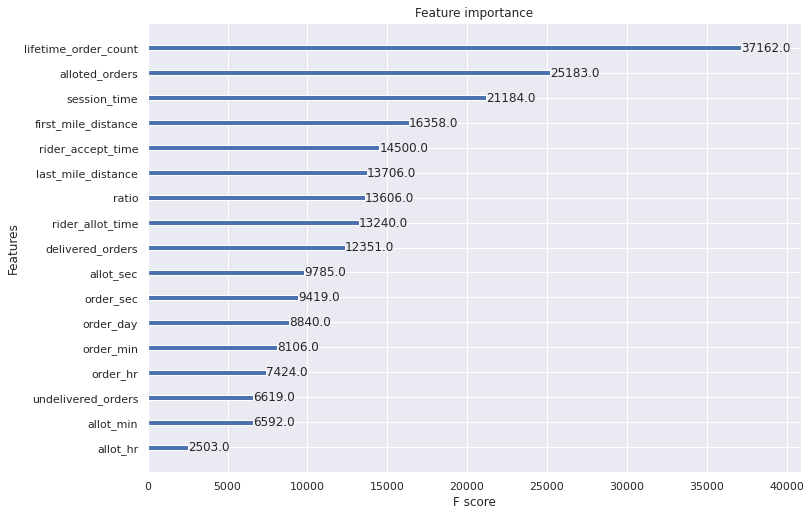

In [80]:
plot_importance(xgb)
plt.show()

<AxesSubplot:xlabel='session_time', ylabel='Count'>

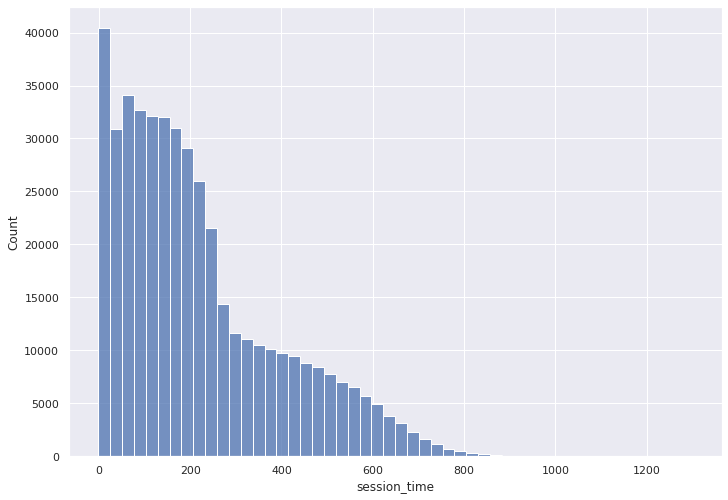

In [57]:
sns.histplot(train['session_time'], bins=50)

<AxesSubplot:xlabel='session_time', ylabel='Count'>

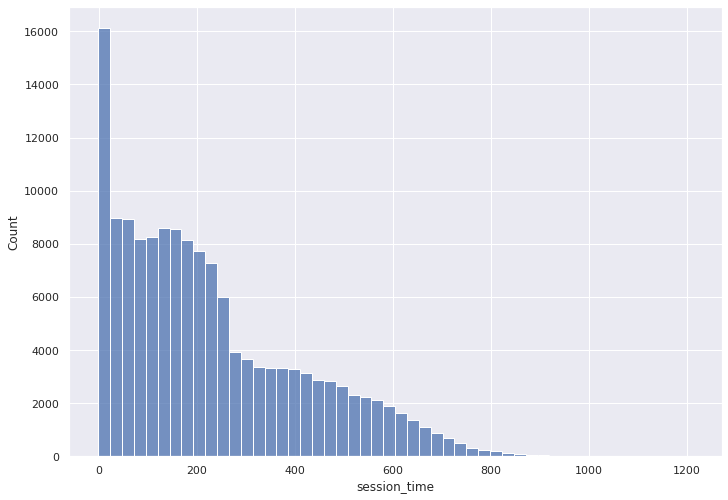

In [58]:
sns.histplot(test['session_time'], bins = 50)

In [82]:
train['lifetime_order_count'].describe()

count    450000.000000
mean        853.540007
std        1502.916267
min          -1.000000
25%         165.000000
50%         396.000000
75%         948.000000
max       30469.000000
Name: lifetime_order_count, dtype: float64

In [83]:
test['lifetime_order_count'].describe()

count    144844.000000
mean        823.425568
std        1508.942991
min          -1.000000
25%         130.000000
50%         353.000000
75%         911.000000
max       30469.000000
Name: lifetime_order_count, dtype: float64

In [17]:
more_drop = ['lifetime_order_count']

train.drop(more_drop, axis = 1, inplace = True)
test.drop(more_drop, axis = 1, inplace = True)

Training

In [36]:
X_data = train.drop('cancelled', axis = 1)
y_data = train['cancelled']

In [19]:
X_data.columns

Index(['first_mile_distance', 'last_mile_distance', 'alloted_orders',
       'delivered_orders', 'undelivered_orders', 'session_time',
       'rider_allot_time', 'rider_accept_time', 'ratio', 'order_day',
       'order_hr', 'order_min', 'order_sec', 'allot_hr', 'allot_min',
       'allot_sec'],
      dtype='object')

In [25]:
y_data.value_counts()

0    355800
1      8895
Name: cancelled, dtype: int64

In [29]:
kfold = StratifiedKFold(random_state = 10, n_splits = 5, shuffle = True)
splits = kfold.split(X_data, y_data)

roc_scores = []
Models = []

for Train, Test in splits:
    X_Train, X_Val, Y_Train, Y_Val = X_data.iloc[Train], X_data.iloc[Test], y_data.iloc[Train], y_data.iloc[Test]
    xgb = XGBClassifier(n_estimators = 2000, max_depth = 8, n_jobs = -1,
                        learning_rate = 0.05, reg_lambda = 0.1, random_state = 10, use_label_encoder=False)
    
    xgb.fit(X_Train, Y_Train, early_stopping_rounds = 50,
            eval_set = [(X_Train, Y_Train), (X_Val, Y_Val)],
            eval_metric = 'logloss', verbose = True)
    pred = xgb.predict_proba(X_Val)[:,1]
    
    roc_scores += [roc_auc_score(Y_Val, pred)]
    print("ROC-AUC Score: ", np.mean(roc_scores))
    Models.append(xgb)

[0]	validation_0-logloss:0.64813	validation_1-logloss:0.64822
[1]	validation_0-logloss:0.60742	validation_1-logloss:0.60755
[2]	validation_0-logloss:0.57046	validation_1-logloss:0.57072
[3]	validation_0-logloss:0.53639	validation_1-logloss:0.53658
[4]	validation_0-logloss:0.50551	validation_1-logloss:0.50568
[5]	validation_0-logloss:0.47710	validation_1-logloss:0.47736
[6]	validation_0-logloss:0.45064	validation_1-logloss:0.45102
[7]	validation_0-logloss:0.42664	validation_1-logloss:0.42704
[8]	validation_0-logloss:0.40442	validation_1-logloss:0.40485
[9]	validation_0-logloss:0.38338	validation_1-logloss:0.38391
[10]	validation_0-logloss:0.36424	validation_1-logloss:0.36479
[11]	validation_0-logloss:0.34612	validation_1-logloss:0.34674
[12]	validation_0-logloss:0.32955	validation_1-logloss:0.33021
[13]	validation_0-logloss:0.31404	validation_1-logloss:0.31479
[14]	validation_0-logloss:0.29965	validation_1-logloss:0.30045
[15]	validation_0-logloss:0.28621	validation_1-logloss:0.28705
[1

[130]	validation_0-logloss:0.06486	validation_1-logloss:0.07451
[131]	validation_0-logloss:0.06472	validation_1-logloss:0.07447
[132]	validation_0-logloss:0.06461	validation_1-logloss:0.07439
[133]	validation_0-logloss:0.06444	validation_1-logloss:0.07436
[134]	validation_0-logloss:0.06435	validation_1-logloss:0.07433
[135]	validation_0-logloss:0.06421	validation_1-logloss:0.07429
[136]	validation_0-logloss:0.06409	validation_1-logloss:0.07425
[137]	validation_0-logloss:0.06397	validation_1-logloss:0.07422
[138]	validation_0-logloss:0.06380	validation_1-logloss:0.07415
[139]	validation_0-logloss:0.06369	validation_1-logloss:0.07411
[140]	validation_0-logloss:0.06358	validation_1-logloss:0.07408
[141]	validation_0-logloss:0.06352	validation_1-logloss:0.07406
[142]	validation_0-logloss:0.06338	validation_1-logloss:0.07399
[143]	validation_0-logloss:0.06330	validation_1-logloss:0.07396
[144]	validation_0-logloss:0.06316	validation_1-logloss:0.07392
[145]	validation_0-logloss:0.06305	valid

[259]	validation_0-logloss:0.05562	validation_1-logloss:0.07218
[260]	validation_0-logloss:0.05557	validation_1-logloss:0.07216
[261]	validation_0-logloss:0.05552	validation_1-logloss:0.07216
[262]	validation_0-logloss:0.05548	validation_1-logloss:0.07214
[263]	validation_0-logloss:0.05536	validation_1-logloss:0.07211
[264]	validation_0-logloss:0.05525	validation_1-logloss:0.07209
[265]	validation_0-logloss:0.05519	validation_1-logloss:0.07208
[266]	validation_0-logloss:0.05513	validation_1-logloss:0.07208
[267]	validation_0-logloss:0.05510	validation_1-logloss:0.07208
[268]	validation_0-logloss:0.05506	validation_1-logloss:0.07208
[269]	validation_0-logloss:0.05496	validation_1-logloss:0.07208
[270]	validation_0-logloss:0.05484	validation_1-logloss:0.07207
[271]	validation_0-logloss:0.05478	validation_1-logloss:0.07206
[272]	validation_0-logloss:0.05471	validation_1-logloss:0.07206
[273]	validation_0-logloss:0.05470	validation_1-logloss:0.07206
[274]	validation_0-logloss:0.05467	valid

[388]	validation_0-logloss:0.04866	validation_1-logloss:0.07146
[389]	validation_0-logloss:0.04861	validation_1-logloss:0.07147
[390]	validation_0-logloss:0.04858	validation_1-logloss:0.07147
[391]	validation_0-logloss:0.04852	validation_1-logloss:0.07148
[392]	validation_0-logloss:0.04851	validation_1-logloss:0.07148
[393]	validation_0-logloss:0.04846	validation_1-logloss:0.07148
[394]	validation_0-logloss:0.04841	validation_1-logloss:0.07147
[395]	validation_0-logloss:0.04837	validation_1-logloss:0.07146
[396]	validation_0-logloss:0.04832	validation_1-logloss:0.07145
[397]	validation_0-logloss:0.04828	validation_1-logloss:0.07146
[398]	validation_0-logloss:0.04821	validation_1-logloss:0.07146
[399]	validation_0-logloss:0.04812	validation_1-logloss:0.07147
[400]	validation_0-logloss:0.04812	validation_1-logloss:0.07147
[401]	validation_0-logloss:0.04809	validation_1-logloss:0.07147
[402]	validation_0-logloss:0.04807	validation_1-logloss:0.07147
[403]	validation_0-logloss:0.04805	valid

[517]	validation_0-logloss:0.04341	validation_1-logloss:0.07128
[518]	validation_0-logloss:0.04337	validation_1-logloss:0.07129
[519]	validation_0-logloss:0.04331	validation_1-logloss:0.07130
[520]	validation_0-logloss:0.04326	validation_1-logloss:0.07129
[521]	validation_0-logloss:0.04324	validation_1-logloss:0.07129
[522]	validation_0-logloss:0.04320	validation_1-logloss:0.07129
[523]	validation_0-logloss:0.04318	validation_1-logloss:0.07129
[524]	validation_0-logloss:0.04317	validation_1-logloss:0.07129
[525]	validation_0-logloss:0.04312	validation_1-logloss:0.07129
[526]	validation_0-logloss:0.04311	validation_1-logloss:0.07129
[527]	validation_0-logloss:0.04310	validation_1-logloss:0.07129
[528]	validation_0-logloss:0.04305	validation_1-logloss:0.07129
[529]	validation_0-logloss:0.04305	validation_1-logloss:0.07129
[530]	validation_0-logloss:0.04301	validation_1-logloss:0.07130
[531]	validation_0-logloss:0.04300	validation_1-logloss:0.07130
[532]	validation_0-logloss:0.04298	valid

[82]	validation_0-logloss:0.07292	validation_1-logloss:0.08068
[83]	validation_0-logloss:0.07261	validation_1-logloss:0.08047
[84]	validation_0-logloss:0.07222	validation_1-logloss:0.08017
[85]	validation_0-logloss:0.07193	validation_1-logloss:0.08000
[86]	validation_0-logloss:0.07166	validation_1-logloss:0.07981
[87]	validation_0-logloss:0.07139	validation_1-logloss:0.07962
[88]	validation_0-logloss:0.07113	validation_1-logloss:0.07946
[89]	validation_0-logloss:0.07086	validation_1-logloss:0.07929
[90]	validation_0-logloss:0.07062	validation_1-logloss:0.07914
[91]	validation_0-logloss:0.07040	validation_1-logloss:0.07902
[92]	validation_0-logloss:0.07013	validation_1-logloss:0.07885
[93]	validation_0-logloss:0.06992	validation_1-logloss:0.07874
[94]	validation_0-logloss:0.06969	validation_1-logloss:0.07861
[95]	validation_0-logloss:0.06941	validation_1-logloss:0.07838
[96]	validation_0-logloss:0.06924	validation_1-logloss:0.07825
[97]	validation_0-logloss:0.06907	validation_1-logloss:

[211]	validation_0-logloss:0.05807	validation_1-logloss:0.07394
[212]	validation_0-logloss:0.05792	validation_1-logloss:0.07394
[213]	validation_0-logloss:0.05786	validation_1-logloss:0.07394
[214]	validation_0-logloss:0.05780	validation_1-logloss:0.07392
[215]	validation_0-logloss:0.05777	validation_1-logloss:0.07390
[216]	validation_0-logloss:0.05772	validation_1-logloss:0.07389
[217]	validation_0-logloss:0.05767	validation_1-logloss:0.07389
[218]	validation_0-logloss:0.05753	validation_1-logloss:0.07384
[219]	validation_0-logloss:0.05747	validation_1-logloss:0.07384
[220]	validation_0-logloss:0.05740	validation_1-logloss:0.07382
[221]	validation_0-logloss:0.05732	validation_1-logloss:0.07382
[222]	validation_0-logloss:0.05730	validation_1-logloss:0.07382
[223]	validation_0-logloss:0.05727	validation_1-logloss:0.07382
[224]	validation_0-logloss:0.05719	validation_1-logloss:0.07380
[225]	validation_0-logloss:0.05716	validation_1-logloss:0.07380
[226]	validation_0-logloss:0.05712	valid

[340]	validation_0-logloss:0.05049	validation_1-logloss:0.07282
[341]	validation_0-logloss:0.05046	validation_1-logloss:0.07281
[342]	validation_0-logloss:0.05040	validation_1-logloss:0.07280
[343]	validation_0-logloss:0.05028	validation_1-logloss:0.07279
[344]	validation_0-logloss:0.05024	validation_1-logloss:0.07279
[345]	validation_0-logloss:0.05021	validation_1-logloss:0.07279
[346]	validation_0-logloss:0.05012	validation_1-logloss:0.07280
[347]	validation_0-logloss:0.05008	validation_1-logloss:0.07280
[348]	validation_0-logloss:0.05002	validation_1-logloss:0.07279
[349]	validation_0-logloss:0.04993	validation_1-logloss:0.07278
[350]	validation_0-logloss:0.04990	validation_1-logloss:0.07279
[351]	validation_0-logloss:0.04982	validation_1-logloss:0.07279
[352]	validation_0-logloss:0.04978	validation_1-logloss:0.07280
[353]	validation_0-logloss:0.04973	validation_1-logloss:0.07279
[354]	validation_0-logloss:0.04967	validation_1-logloss:0.07280
[355]	validation_0-logloss:0.04963	valid

[469]	validation_0-logloss:0.04437	validation_1-logloss:0.07244
[470]	validation_0-logloss:0.04431	validation_1-logloss:0.07242
[471]	validation_0-logloss:0.04429	validation_1-logloss:0.07243
[472]	validation_0-logloss:0.04424	validation_1-logloss:0.07243
[473]	validation_0-logloss:0.04423	validation_1-logloss:0.07243
[474]	validation_0-logloss:0.04416	validation_1-logloss:0.07243
[475]	validation_0-logloss:0.04410	validation_1-logloss:0.07242
[476]	validation_0-logloss:0.04403	validation_1-logloss:0.07240
[477]	validation_0-logloss:0.04400	validation_1-logloss:0.07240
[478]	validation_0-logloss:0.04399	validation_1-logloss:0.07240
[479]	validation_0-logloss:0.04394	validation_1-logloss:0.07240
[480]	validation_0-logloss:0.04392	validation_1-logloss:0.07240
[481]	validation_0-logloss:0.04389	validation_1-logloss:0.07241
[482]	validation_0-logloss:0.04383	validation_1-logloss:0.07240
[483]	validation_0-logloss:0.04383	validation_1-logloss:0.07240
[484]	validation_0-logloss:0.04377	valid

[598]	validation_0-logloss:0.03896	validation_1-logloss:0.07227
[599]	validation_0-logloss:0.03894	validation_1-logloss:0.07228
[600]	validation_0-logloss:0.03894	validation_1-logloss:0.07228
[601]	validation_0-logloss:0.03894	validation_1-logloss:0.07228
[602]	validation_0-logloss:0.03891	validation_1-logloss:0.07228
[603]	validation_0-logloss:0.03888	validation_1-logloss:0.07228
[604]	validation_0-logloss:0.03883	validation_1-logloss:0.07227
[605]	validation_0-logloss:0.03875	validation_1-logloss:0.07228
[606]	validation_0-logloss:0.03873	validation_1-logloss:0.07227
[607]	validation_0-logloss:0.03868	validation_1-logloss:0.07229
[608]	validation_0-logloss:0.03863	validation_1-logloss:0.07229
[609]	validation_0-logloss:0.03862	validation_1-logloss:0.07230
[610]	validation_0-logloss:0.03854	validation_1-logloss:0.07230
[611]	validation_0-logloss:0.03850	validation_1-logloss:0.07230
[612]	validation_0-logloss:0.03846	validation_1-logloss:0.07232
[613]	validation_0-logloss:0.03845	valid

[99]	validation_0-logloss:0.06960	validation_1-logloss:0.07513
[100]	validation_0-logloss:0.06937	validation_1-logloss:0.07503
[101]	validation_0-logloss:0.06922	validation_1-logloss:0.07490
[102]	validation_0-logloss:0.06903	validation_1-logloss:0.07480
[103]	validation_0-logloss:0.06878	validation_1-logloss:0.07466
[104]	validation_0-logloss:0.06860	validation_1-logloss:0.07458
[105]	validation_0-logloss:0.06841	validation_1-logloss:0.07450
[106]	validation_0-logloss:0.06828	validation_1-logloss:0.07440
[107]	validation_0-logloss:0.06806	validation_1-logloss:0.07432
[108]	validation_0-logloss:0.06794	validation_1-logloss:0.07422
[109]	validation_0-logloss:0.06771	validation_1-logloss:0.07411
[110]	validation_0-logloss:0.06762	validation_1-logloss:0.07407
[111]	validation_0-logloss:0.06744	validation_1-logloss:0.07396
[112]	validation_0-logloss:0.06721	validation_1-logloss:0.07388
[113]	validation_0-logloss:0.06706	validation_1-logloss:0.07382
[114]	validation_0-logloss:0.06697	valida

[228]	validation_0-logloss:0.05722	validation_1-logloss:0.07088
[229]	validation_0-logloss:0.05713	validation_1-logloss:0.07086
[230]	validation_0-logloss:0.05713	validation_1-logloss:0.07086
[231]	validation_0-logloss:0.05706	validation_1-logloss:0.07086
[232]	validation_0-logloss:0.05702	validation_1-logloss:0.07083
[233]	validation_0-logloss:0.05697	validation_1-logloss:0.07083
[234]	validation_0-logloss:0.05695	validation_1-logloss:0.07082
[235]	validation_0-logloss:0.05688	validation_1-logloss:0.07081
[236]	validation_0-logloss:0.05679	validation_1-logloss:0.07079
[237]	validation_0-logloss:0.05676	validation_1-logloss:0.07079
[238]	validation_0-logloss:0.05672	validation_1-logloss:0.07080
[239]	validation_0-logloss:0.05666	validation_1-logloss:0.07080
[240]	validation_0-logloss:0.05659	validation_1-logloss:0.07078
[241]	validation_0-logloss:0.05655	validation_1-logloss:0.07076
[242]	validation_0-logloss:0.05643	validation_1-logloss:0.07071
[243]	validation_0-logloss:0.05636	valid

[357]	validation_0-logloss:0.05021	validation_1-logloss:0.07025
[358]	validation_0-logloss:0.05019	validation_1-logloss:0.07025
[359]	validation_0-logloss:0.05006	validation_1-logloss:0.07025
[360]	validation_0-logloss:0.04991	validation_1-logloss:0.07026
[361]	validation_0-logloss:0.04987	validation_1-logloss:0.07026
[362]	validation_0-logloss:0.04986	validation_1-logloss:0.07027
[363]	validation_0-logloss:0.04981	validation_1-logloss:0.07028
[364]	validation_0-logloss:0.04978	validation_1-logloss:0.07027
[365]	validation_0-logloss:0.04970	validation_1-logloss:0.07028
[366]	validation_0-logloss:0.04963	validation_1-logloss:0.07026
[367]	validation_0-logloss:0.04960	validation_1-logloss:0.07026
[368]	validation_0-logloss:0.04957	validation_1-logloss:0.07026
[369]	validation_0-logloss:0.04954	validation_1-logloss:0.07026
[370]	validation_0-logloss:0.04949	validation_1-logloss:0.07026
[371]	validation_0-logloss:0.04947	validation_1-logloss:0.07027
[372]	validation_0-logloss:0.04943	valid

[486]	validation_0-logloss:0.04454	validation_1-logloss:0.07010
[487]	validation_0-logloss:0.04451	validation_1-logloss:0.07010
[488]	validation_0-logloss:0.04445	validation_1-logloss:0.07009
[489]	validation_0-logloss:0.04441	validation_1-logloss:0.07010
[490]	validation_0-logloss:0.04440	validation_1-logloss:0.07010
[491]	validation_0-logloss:0.04438	validation_1-logloss:0.07010
[492]	validation_0-logloss:0.04435	validation_1-logloss:0.07010
[493]	validation_0-logloss:0.04430	validation_1-logloss:0.07010
[494]	validation_0-logloss:0.04429	validation_1-logloss:0.07010
[495]	validation_0-logloss:0.04428	validation_1-logloss:0.07010
[496]	validation_0-logloss:0.04428	validation_1-logloss:0.07010
[497]	validation_0-logloss:0.04419	validation_1-logloss:0.07011
[498]	validation_0-logloss:0.04415	validation_1-logloss:0.07011
[499]	validation_0-logloss:0.04409	validation_1-logloss:0.07009
[500]	validation_0-logloss:0.04405	validation_1-logloss:0.07009
[501]	validation_0-logloss:0.04402	valid

[615]	validation_0-logloss:0.03946	validation_1-logloss:0.06988
[616]	validation_0-logloss:0.03945	validation_1-logloss:0.06988
[617]	validation_0-logloss:0.03941	validation_1-logloss:0.06988
[618]	validation_0-logloss:0.03936	validation_1-logloss:0.06988
[619]	validation_0-logloss:0.03931	validation_1-logloss:0.06988
[620]	validation_0-logloss:0.03924	validation_1-logloss:0.06988
[621]	validation_0-logloss:0.03922	validation_1-logloss:0.06988
[622]	validation_0-logloss:0.03920	validation_1-logloss:0.06987
[623]	validation_0-logloss:0.03916	validation_1-logloss:0.06988
[624]	validation_0-logloss:0.03913	validation_1-logloss:0.06988
[625]	validation_0-logloss:0.03912	validation_1-logloss:0.06988
[626]	validation_0-logloss:0.03908	validation_1-logloss:0.06987
[627]	validation_0-logloss:0.03905	validation_1-logloss:0.06987
[628]	validation_0-logloss:0.03899	validation_1-logloss:0.06986
[629]	validation_0-logloss:0.03895	validation_1-logloss:0.06986
[630]	validation_0-logloss:0.03889	valid

[14]	validation_0-logloss:0.29976	validation_1-logloss:0.30008
[15]	validation_0-logloss:0.28624	validation_1-logloss:0.28656
[16]	validation_0-logloss:0.27369	validation_1-logloss:0.27402
[17]	validation_0-logloss:0.26165	validation_1-logloss:0.26201
[18]	validation_0-logloss:0.25068	validation_1-logloss:0.25105
[19]	validation_0-logloss:0.24043	validation_1-logloss:0.24083
[20]	validation_0-logloss:0.23068	validation_1-logloss:0.23109
[21]	validation_0-logloss:0.22154	validation_1-logloss:0.22199
[22]	validation_0-logloss:0.21303	validation_1-logloss:0.21350
[23]	validation_0-logloss:0.20493	validation_1-logloss:0.20544
[24]	validation_0-logloss:0.19743	validation_1-logloss:0.19797
[25]	validation_0-logloss:0.19040	validation_1-logloss:0.19095
[26]	validation_0-logloss:0.18370	validation_1-logloss:0.18428
[27]	validation_0-logloss:0.17733	validation_1-logloss:0.17794
[28]	validation_0-logloss:0.17133	validation_1-logloss:0.17198
[29]	validation_0-logloss:0.16575	validation_1-logloss:

[144]	validation_0-logloss:0.06357	validation_1-logloss:0.07162
[145]	validation_0-logloss:0.06350	validation_1-logloss:0.07160
[146]	validation_0-logloss:0.06337	validation_1-logloss:0.07156
[147]	validation_0-logloss:0.06327	validation_1-logloss:0.07149
[148]	validation_0-logloss:0.06319	validation_1-logloss:0.07148
[149]	validation_0-logloss:0.06313	validation_1-logloss:0.07146
[150]	validation_0-logloss:0.06302	validation_1-logloss:0.07142
[151]	validation_0-logloss:0.06290	validation_1-logloss:0.07141
[152]	validation_0-logloss:0.06283	validation_1-logloss:0.07141
[153]	validation_0-logloss:0.06275	validation_1-logloss:0.07138
[154]	validation_0-logloss:0.06261	validation_1-logloss:0.07133
[155]	validation_0-logloss:0.06252	validation_1-logloss:0.07129
[156]	validation_0-logloss:0.06243	validation_1-logloss:0.07128
[157]	validation_0-logloss:0.06235	validation_1-logloss:0.07126
[158]	validation_0-logloss:0.06225	validation_1-logloss:0.07124
[159]	validation_0-logloss:0.06214	valid

[273]	validation_0-logloss:0.05456	validation_1-logloss:0.06991
[274]	validation_0-logloss:0.05453	validation_1-logloss:0.06991
[275]	validation_0-logloss:0.05452	validation_1-logloss:0.06991
[276]	validation_0-logloss:0.05445	validation_1-logloss:0.06989
[277]	validation_0-logloss:0.05444	validation_1-logloss:0.06989
[278]	validation_0-logloss:0.05441	validation_1-logloss:0.06988
[279]	validation_0-logloss:0.05440	validation_1-logloss:0.06988
[280]	validation_0-logloss:0.05430	validation_1-logloss:0.06986
[281]	validation_0-logloss:0.05429	validation_1-logloss:0.06986
[282]	validation_0-logloss:0.05418	validation_1-logloss:0.06984
[283]	validation_0-logloss:0.05413	validation_1-logloss:0.06983
[284]	validation_0-logloss:0.05411	validation_1-logloss:0.06982
[285]	validation_0-logloss:0.05404	validation_1-logloss:0.06981
[286]	validation_0-logloss:0.05399	validation_1-logloss:0.06982
[287]	validation_0-logloss:0.05398	validation_1-logloss:0.06981
[288]	validation_0-logloss:0.05394	valid

[402]	validation_0-logloss:0.04800	validation_1-logloss:0.06935
[403]	validation_0-logloss:0.04793	validation_1-logloss:0.06933
[404]	validation_0-logloss:0.04791	validation_1-logloss:0.06933
[405]	validation_0-logloss:0.04784	validation_1-logloss:0.06932
[406]	validation_0-logloss:0.04777	validation_1-logloss:0.06931
[407]	validation_0-logloss:0.04773	validation_1-logloss:0.06931
[408]	validation_0-logloss:0.04764	validation_1-logloss:0.06931
[409]	validation_0-logloss:0.04758	validation_1-logloss:0.06928
[410]	validation_0-logloss:0.04752	validation_1-logloss:0.06928
[411]	validation_0-logloss:0.04748	validation_1-logloss:0.06928
[412]	validation_0-logloss:0.04741	validation_1-logloss:0.06927
[413]	validation_0-logloss:0.04736	validation_1-logloss:0.06927
[414]	validation_0-logloss:0.04734	validation_1-logloss:0.06926
[415]	validation_0-logloss:0.04729	validation_1-logloss:0.06926
[416]	validation_0-logloss:0.04728	validation_1-logloss:0.06926
[417]	validation_0-logloss:0.04723	valid

[531]	validation_0-logloss:0.04264	validation_1-logloss:0.06902
[532]	validation_0-logloss:0.04260	validation_1-logloss:0.06902
[533]	validation_0-logloss:0.04258	validation_1-logloss:0.06902
[534]	validation_0-logloss:0.04253	validation_1-logloss:0.06903
[535]	validation_0-logloss:0.04247	validation_1-logloss:0.06903
[536]	validation_0-logloss:0.04245	validation_1-logloss:0.06903
[537]	validation_0-logloss:0.04241	validation_1-logloss:0.06902
[538]	validation_0-logloss:0.04231	validation_1-logloss:0.06903
[539]	validation_0-logloss:0.04227	validation_1-logloss:0.06903
[540]	validation_0-logloss:0.04225	validation_1-logloss:0.06903
[541]	validation_0-logloss:0.04219	validation_1-logloss:0.06903
[542]	validation_0-logloss:0.04212	validation_1-logloss:0.06901
[543]	validation_0-logloss:0.04208	validation_1-logloss:0.06901
[544]	validation_0-logloss:0.04201	validation_1-logloss:0.06901
[545]	validation_0-logloss:0.04201	validation_1-logloss:0.06902
[546]	validation_0-logloss:0.04199	valid

[105]	validation_0-logloss:0.06848	validation_1-logloss:0.07679
[106]	validation_0-logloss:0.06835	validation_1-logloss:0.07669
[107]	validation_0-logloss:0.06820	validation_1-logloss:0.07664
[108]	validation_0-logloss:0.06802	validation_1-logloss:0.07650
[109]	validation_0-logloss:0.06785	validation_1-logloss:0.07642
[110]	validation_0-logloss:0.06766	validation_1-logloss:0.07626
[111]	validation_0-logloss:0.06757	validation_1-logloss:0.07623
[112]	validation_0-logloss:0.06731	validation_1-logloss:0.07607
[113]	validation_0-logloss:0.06709	validation_1-logloss:0.07592
[114]	validation_0-logloss:0.06696	validation_1-logloss:0.07582
[115]	validation_0-logloss:0.06688	validation_1-logloss:0.07579
[116]	validation_0-logloss:0.06677	validation_1-logloss:0.07576
[117]	validation_0-logloss:0.06667	validation_1-logloss:0.07571
[118]	validation_0-logloss:0.06649	validation_1-logloss:0.07565
[119]	validation_0-logloss:0.06640	validation_1-logloss:0.07560
[120]	validation_0-logloss:0.06622	valid

[234]	validation_0-logloss:0.05667	validation_1-logloss:0.07278
[235]	validation_0-logloss:0.05655	validation_1-logloss:0.07276
[236]	validation_0-logloss:0.05648	validation_1-logloss:0.07275
[237]	validation_0-logloss:0.05647	validation_1-logloss:0.07276
[238]	validation_0-logloss:0.05639	validation_1-logloss:0.07276
[239]	validation_0-logloss:0.05637	validation_1-logloss:0.07277
[240]	validation_0-logloss:0.05631	validation_1-logloss:0.07275
[241]	validation_0-logloss:0.05623	validation_1-logloss:0.07274
[242]	validation_0-logloss:0.05612	validation_1-logloss:0.07272
[243]	validation_0-logloss:0.05609	validation_1-logloss:0.07272
[244]	validation_0-logloss:0.05604	validation_1-logloss:0.07272
[245]	validation_0-logloss:0.05598	validation_1-logloss:0.07273
[246]	validation_0-logloss:0.05592	validation_1-logloss:0.07273
[247]	validation_0-logloss:0.05585	validation_1-logloss:0.07271
[248]	validation_0-logloss:0.05577	validation_1-logloss:0.07271
[249]	validation_0-logloss:0.05574	valid

[363]	validation_0-logloss:0.04892	validation_1-logloss:0.07184
[364]	validation_0-logloss:0.04891	validation_1-logloss:0.07184
[365]	validation_0-logloss:0.04888	validation_1-logloss:0.07183
[366]	validation_0-logloss:0.04887	validation_1-logloss:0.07183
[367]	validation_0-logloss:0.04883	validation_1-logloss:0.07185
[368]	validation_0-logloss:0.04878	validation_1-logloss:0.07182
[369]	validation_0-logloss:0.04870	validation_1-logloss:0.07183
[370]	validation_0-logloss:0.04865	validation_1-logloss:0.07184
[371]	validation_0-logloss:0.04861	validation_1-logloss:0.07184
[372]	validation_0-logloss:0.04858	validation_1-logloss:0.07185
[373]	validation_0-logloss:0.04856	validation_1-logloss:0.07185
[374]	validation_0-logloss:0.04855	validation_1-logloss:0.07185
[375]	validation_0-logloss:0.04849	validation_1-logloss:0.07185
[376]	validation_0-logloss:0.04842	validation_1-logloss:0.07183
[377]	validation_0-logloss:0.04836	validation_1-logloss:0.07183
[378]	validation_0-logloss:0.04834	valid

[492]	validation_0-logloss:0.04302	validation_1-logloss:0.07159
[493]	validation_0-logloss:0.04301	validation_1-logloss:0.07159
[494]	validation_0-logloss:0.04297	validation_1-logloss:0.07158
[495]	validation_0-logloss:0.04294	validation_1-logloss:0.07158
[496]	validation_0-logloss:0.04285	validation_1-logloss:0.07158
[497]	validation_0-logloss:0.04278	validation_1-logloss:0.07157
[498]	validation_0-logloss:0.04275	validation_1-logloss:0.07157
[499]	validation_0-logloss:0.04270	validation_1-logloss:0.07157
[500]	validation_0-logloss:0.04262	validation_1-logloss:0.07156
[501]	validation_0-logloss:0.04254	validation_1-logloss:0.07155
[502]	validation_0-logloss:0.04251	validation_1-logloss:0.07155
[503]	validation_0-logloss:0.04246	validation_1-logloss:0.07156
[504]	validation_0-logloss:0.04241	validation_1-logloss:0.07154
[505]	validation_0-logloss:0.04236	validation_1-logloss:0.07154
[506]	validation_0-logloss:0.04232	validation_1-logloss:0.07154
[507]	validation_0-logloss:0.04231	valid

In [31]:
test_orderid = pd.read_csv('Data/test.csv')['order_id']

In [32]:
pred = []
for model in Models:
    pred.append(model.predict_proba(test))

print(np.array(pred).shape)
print(np.mean(pred, axis = 0)[:,0].shape)
#pred = np.max(np.mean(pred, axis = 0), axis = 1)
pred = np.mean(pred, axis = 0)[:,1]

pred_file = {'order_id': test_orderid, 'cancelled': pred}
pred_file = pd.DataFrame(pred_file)
pred_file.to_csv('Sub.csv', index = False)

(5, 144844, 2)
(144844,)
